<a href="https://colab.research.google.com/github/josh-millar/josh-millar/blob/main/NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [24]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [26]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [27]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    """Takes each line as a list and converts to a tuple of the form
    (label, statement). Needs the info that idx 1 and 2 are the 
    labels and statements, respectively"""
    full_label = data_line[1]
    statement = data_line[2]
    label = convert_label(full_label)
    return (label, statement)


In [28]:
import re
# Input: a string of one statement
def pre_process(text):
    """ Takes a statement as a single string, removes puncuation and returns
    a list of tokens"""
    # remove punctuation (i.e. anything that isn't a word or space)
    text = re.sub(r'[^\w\s]', '', text)
    # convert to lower case and split by whitespace
    text_split_lower = text.lower().split()
    return text_split_lower

# Question 2: Basic Feature Extraction (20 marks)

In [29]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    """Given a token (a list of words), returns a dictionary as a 
    bag of words. Additionally, update a global dictionary"""
    feature_vector = {}
    for token in tokens:
      # first update feature vectors
      if token in feature_vector:
        feature_vector[token] += 1
      else:
        feature_vector[token] = 1
      # now update global dictionary in same way
      if token in global_feature_dict:
        global_feature_dict[token] += 1
      else:
        global_feature_dict[token] = 1
    return feature_vector

In [30]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [105]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset) / folds) + 1

    for i in range(0, len(dataset), int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # split the dataset into a training and cross validation set
        cv_set = dataset[i:i+fold_size]
        training_set = dataset[0:i] + dataset[i+fold_size::]
        # train data on the training set
        classifier = train_classifier(training_set)
        # split the cv set into tokens and labels
        cv_dicts = [d[0] for d in cv_set]
        y_true = [y[1] for y in cv_set]
        # predict the labels using the classifier
        y_pred = predict_labels(cv_dicts, classifier)
        # get the metrics for this fold, add them to the running total 
        metrics_dict = classification_report(y_true, y_pred, output_dict=True)
        this_result = [
            metrics_dict["weighted avg"]["precision"],
            metrics_dict["weighted avg"]["recall"],
            metrics_dict["weighted avg"]["f1-score"],
            metrics_dict["accuracy"]
            ]
        if not results:
          results = this_result
        else:
          results = [sum(x) for x in zip(results, this_result)]
    # convert the summed results to an average, then create a dictionary
    cv_results_values = [result / folds for result in results]
    cv_results_keys = ["precision", "recall", "f1-score", "accuracy"]
    cv_results = dict(zip(cv_results_keys, cv_results_values))
    return cv_results

In [106]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [107]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')
split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')
# print([x[1] for x in raw_data if x[0][-1] == "!"])

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13407


In [108]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


{'precision': 0.5657470725260281,
 'recall': 0.5644863630902319,
 'f1-score': 0.5647300664729743,
 'accuracy': 0.5644863630902319}

# 4. Error Analysis (10 marks)

Training Classifier...


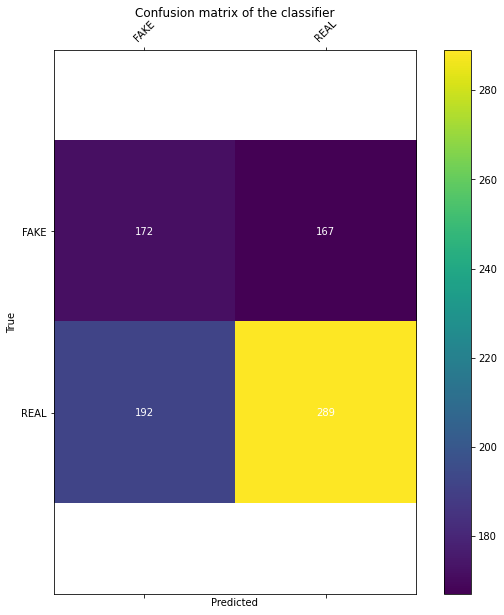

In [104]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

# test on first fold, i.e. train_data[0:fold_size]
folds = 10
fold_size = int(len(train_data) / folds) + 1
training_set = train_data[fold_size::]
cv_set = train_data[0:fold_size]
classifier = train_classifier(training_set)
# get the text and the labels from the cv
cv_dicts = [d[0] for d in cv_set]
y_true = [y[1] for y in cv_set]
y_pred = predict_labels(cv_dicts, classifier)
confusion_matrix_heatmap(y_true, y_pred, ["FAKE", "REAL"])
# create two tsvs to write the examples to
with open("false_negatives.tsv", "w") as fngs:
    with open("false_positives.tsv", "w") as fps:
        fngs.write(
            "%s\t %s\t %s\n" %("Statement", "True label", "Predicted label")
            )
        fps.write(
            "%s\t %s\t %s\n" %("Statement", "True label", "Predicted label")
            )
        for idx in range(0, fold_size):
            if y_true[idx] != y_pred[idx] and y_true[idx] == "FAKE":
                fngs.write(
                    "%s\t %s\t %s\n" %(raw_data[idx][0], y_true[idx], y_pred[idx])
                    )
            elif y_true[idx] != y_pred[idx] and y_true[idx] == "REAL":
                fps.write(
                    "%s\t %s\t %s\n" %(raw_data[idx][0], y_true[idx], y_pred[idx])
                    )
          
    

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [36]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])